<a href="https://colab.research.google.com/github/plutasnyy/recognizeeyebloodvessels/blob/master/recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importy

In [1]:
import logging
import os
import glob
import random
from IPython import get_ipython

import keras
from keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD

import tensorflow as tf
from tensorflow.python.client import device_lib

from collections import Counter
from time import gmtime, strftime

from PIL import Image
from copy import deepcopy
from numpy import asarray
from skimage import transform, exposure
from skimage.filters import sobel

import sklearn
import cv2
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


### Zmiene

In [2]:
PATCH_SIZE = 48
HALF_OF_PATCH_SIZE = int(PATCH_SIZE / 2)
SPLIT_PATCHES_SIZE = 500
BASE_PATH = 'data'
IMAGE_PATH = BASE_PATH + '/image/{}.jpg'
MASK_PATH = BASE_PATH + '/mask/{}.tif'
MANUAL_PATH = BASE_PATH + '/manual/{}.tif'
FILE_PATH = 'new_best2.hdf5'
LOG_DIR = 'tb_logs'
LONG_EDGE_SIZE = None


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.basicConfig(level=logging.DEBUG)

### Tensorboard

In [1]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# import os
# if not os.path.exists(LOG_DIR):
#   os.makedirs(LOG_DIR)
  
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR))

# get_ipython().system_raw('./ngrok http 6006 &')

# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

### Image Processing

In [3]:
def correct_image(image):
    #TODO run this function only when process tensor, not during creating an object
    logging.info('Correct an image with shape: {}'.format(image.shape))
    bw_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_adapt = exposure.equalize_adapthist(bw_image)
    logarithmic_corrected = exposure.adjust_log(image_adapt, 1)
    return logarithmic_corrected
  
def draw_images(images: list):
    logging.info('Draw {} images'.format(len(images)))
    size = np.ceil(np.sqrt(len(images)))
    fig = plt.figure(figsize=(32, 32))
    for i, img in enumerate(images):
        fig.add_subplot(size, size, i + 1)
        plt.imshow(img)
    plt.show()


def draw_grey_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

### Tensor

In [11]:
class Tensor:
    def __init__(self, base_image, vessels, mask, id):
        assert base_image.size == vessels.size, 'Images have different sizes'
        assert mask.size == vessels.size, 'Mask has wrong size'

        # long_edge = max(base_image.size)
        # scale = LONG_EDGE_SIZE / long_edge
        scale=1
        w, h = base_image.size
        c = len(base_image.getbands())
        w, h = int(w * scale), int(h * scale)
        logging.info(
            'Tensor resize from {} to {} with {} scale'.format((base_image.size, c), (w, h, c), round(scale, 2)))

        self.base_image = asarray(base_image.resize((w, h), resample=Image.NEAREST))  # 0-255
        self.corrected = correct_image(self.base_image)  # 0-1 TODO VERY BAD DEPENDENCY it should be moved out from this class
        self.vessels = (asarray(vessels.resize((w, h), resample=Image.NEAREST)) / 255).astype(int)  # 0-1

        if len(self.vessels.shape) == 3:
            self.vessels = self.vessels[:, :, 1]
        self.mask = asarray(mask.resize((w,h))).astype(int) / 255
        self.mask = self.mask[:,:,1].astype(int)
        print(self.mask.shape)
        draw_grey_image(self.mask)
        draw_images([mask,self.mask])
        print(np.amax(self.mask))
        self.id = id

    def draw_tensor(self):
        """
        TODO This is very bad dependency to other functionality, this class should be independent, it was created only for tests and it should be removed when will be unused
        """
        draw_images([self.base_image, self.corrected, self.vessels, self.mask])

    def __repr__(self):
        return '{}: base_image: {}'.format(self.id, self.base_image.shape)

### Samples

In [5]:
def create_tensor_from_file():
    images_path = sorted(glob.glob('data/image/*'))
    for i in range(1, len(images_path)+1):
        logging.info('Process i: {}'.format(i))
        base_image = Image.open(IMAGE_PATH.format(i))
        mask = Image.open(MASK_PATH.format(i))
        vessels = Image.open(MANUAL_PATH.format(i))
        yield Tensor(base_image, vessels, mask, i)

def create_samples_from_tensor(tensor: Tensor):
    logging.info('Create samples from tensor: {}'.format(tensor))
    X, Y = list(), list()
    for (x, y), value in np.ndenumerate(tensor.mask):
        if x + PATCH_SIZE <= tensor.corrected.shape[0] and y + PATCH_SIZE <= tensor.corrected.shape[1]:
            center_x, center_y = x + HALF_OF_PATCH_SIZE, y + HALF_OF_PATCH_SIZE
            if tensor.mask[center_x][center_y] == 1:
                X.append(tensor.corrected[x: x + PATCH_SIZE, y: y + PATCH_SIZE])
                Y.append(tensor.vessels[center_x][center_y])
    return X, Y

def random_undersampling(X, y):
    """
    In this moment we will lose order of samples
    """
    minority_value, majority_value = 1, 0
    new_X, new_y = list(), list()
    length = len(y)
    quantity_of_minority = sum(y)
    quantity_of_majority = length - quantity_of_minority
    indexes_list = list(range(length))
    random.shuffle(indexes_list)
    skipped, to_skip = 0, quantity_of_majority - quantity_of_minority
    assert to_skip >= 0
    for index in indexes_list:
        if skipped < to_skip and y[index] == majority_value:
            skipped += 1
        else:
            new_X.append(X[index])
            new_y.append(y[index])

    result_X, result_Y = sklearn.utils.shuffle(new_X, new_y, random_state=0)
    return result_X, result_Y


def preprocess_image(tensor: Tensor):
    logging.info('Started preprocess a tensor: {}'.format(tensor))
    edge_sobel = sobel(tensor.corrected)
    normalized_image = cv2.normalize(edge_sobel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    _, thresholded_image = cv2.threshold(normalized_image, 20, 255, cv2.THRESH_BINARY)
    cleaned_image = (thresholded_image * tensor.mask).astype(int)
    return np.invert(cleaned_image)

### Collect patches

INFO:root:Process i: 1
INFO:root:Tensor resize from ((3504, 2336), 3) to (3504, 2336, 3) with 1 scale
INFO:root:Correct an image with shape: (2336, 3504, 3)
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
INFO:root:Draw 2 images
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
INFO:root:Draw 4 images
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:up

(2336, 3504)
1


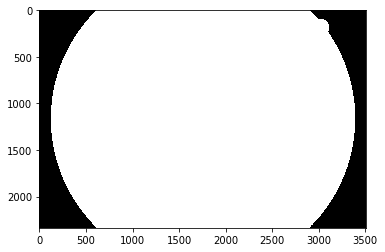

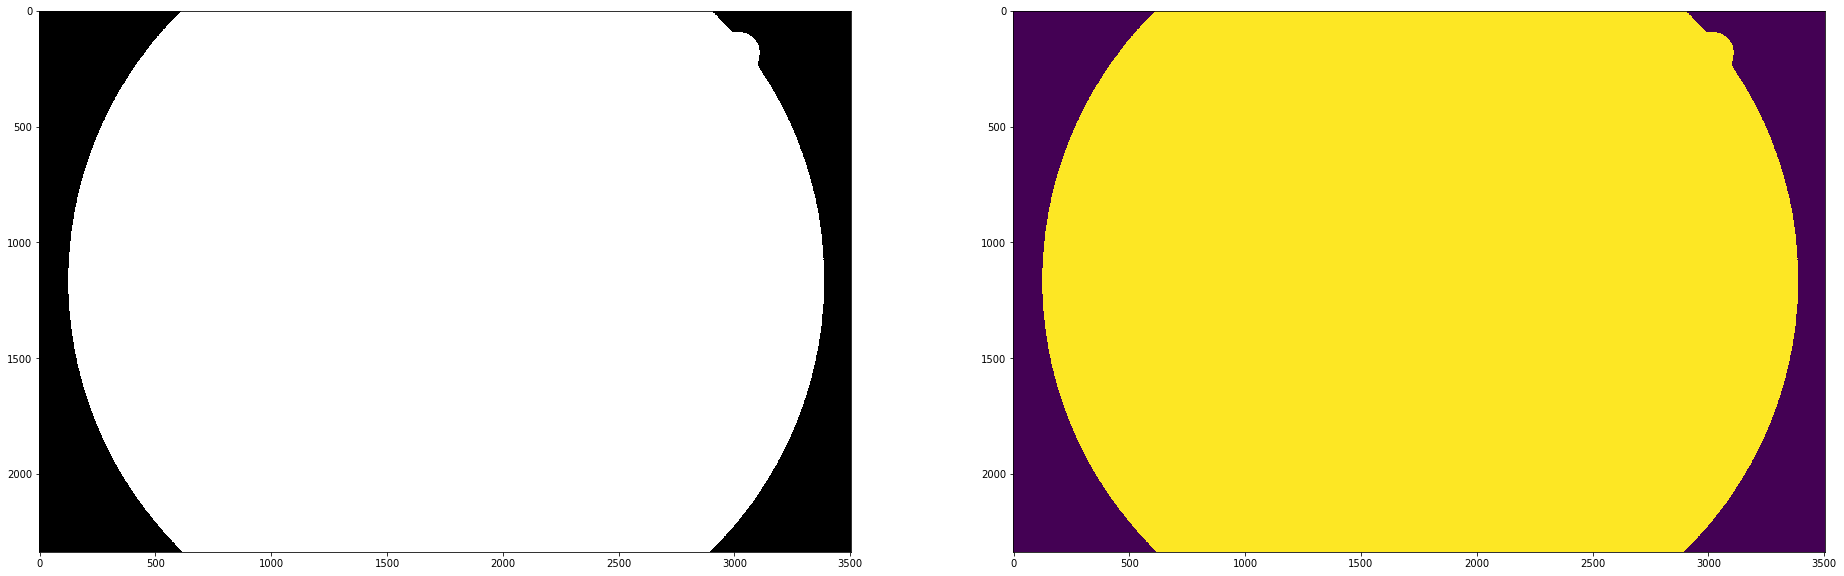

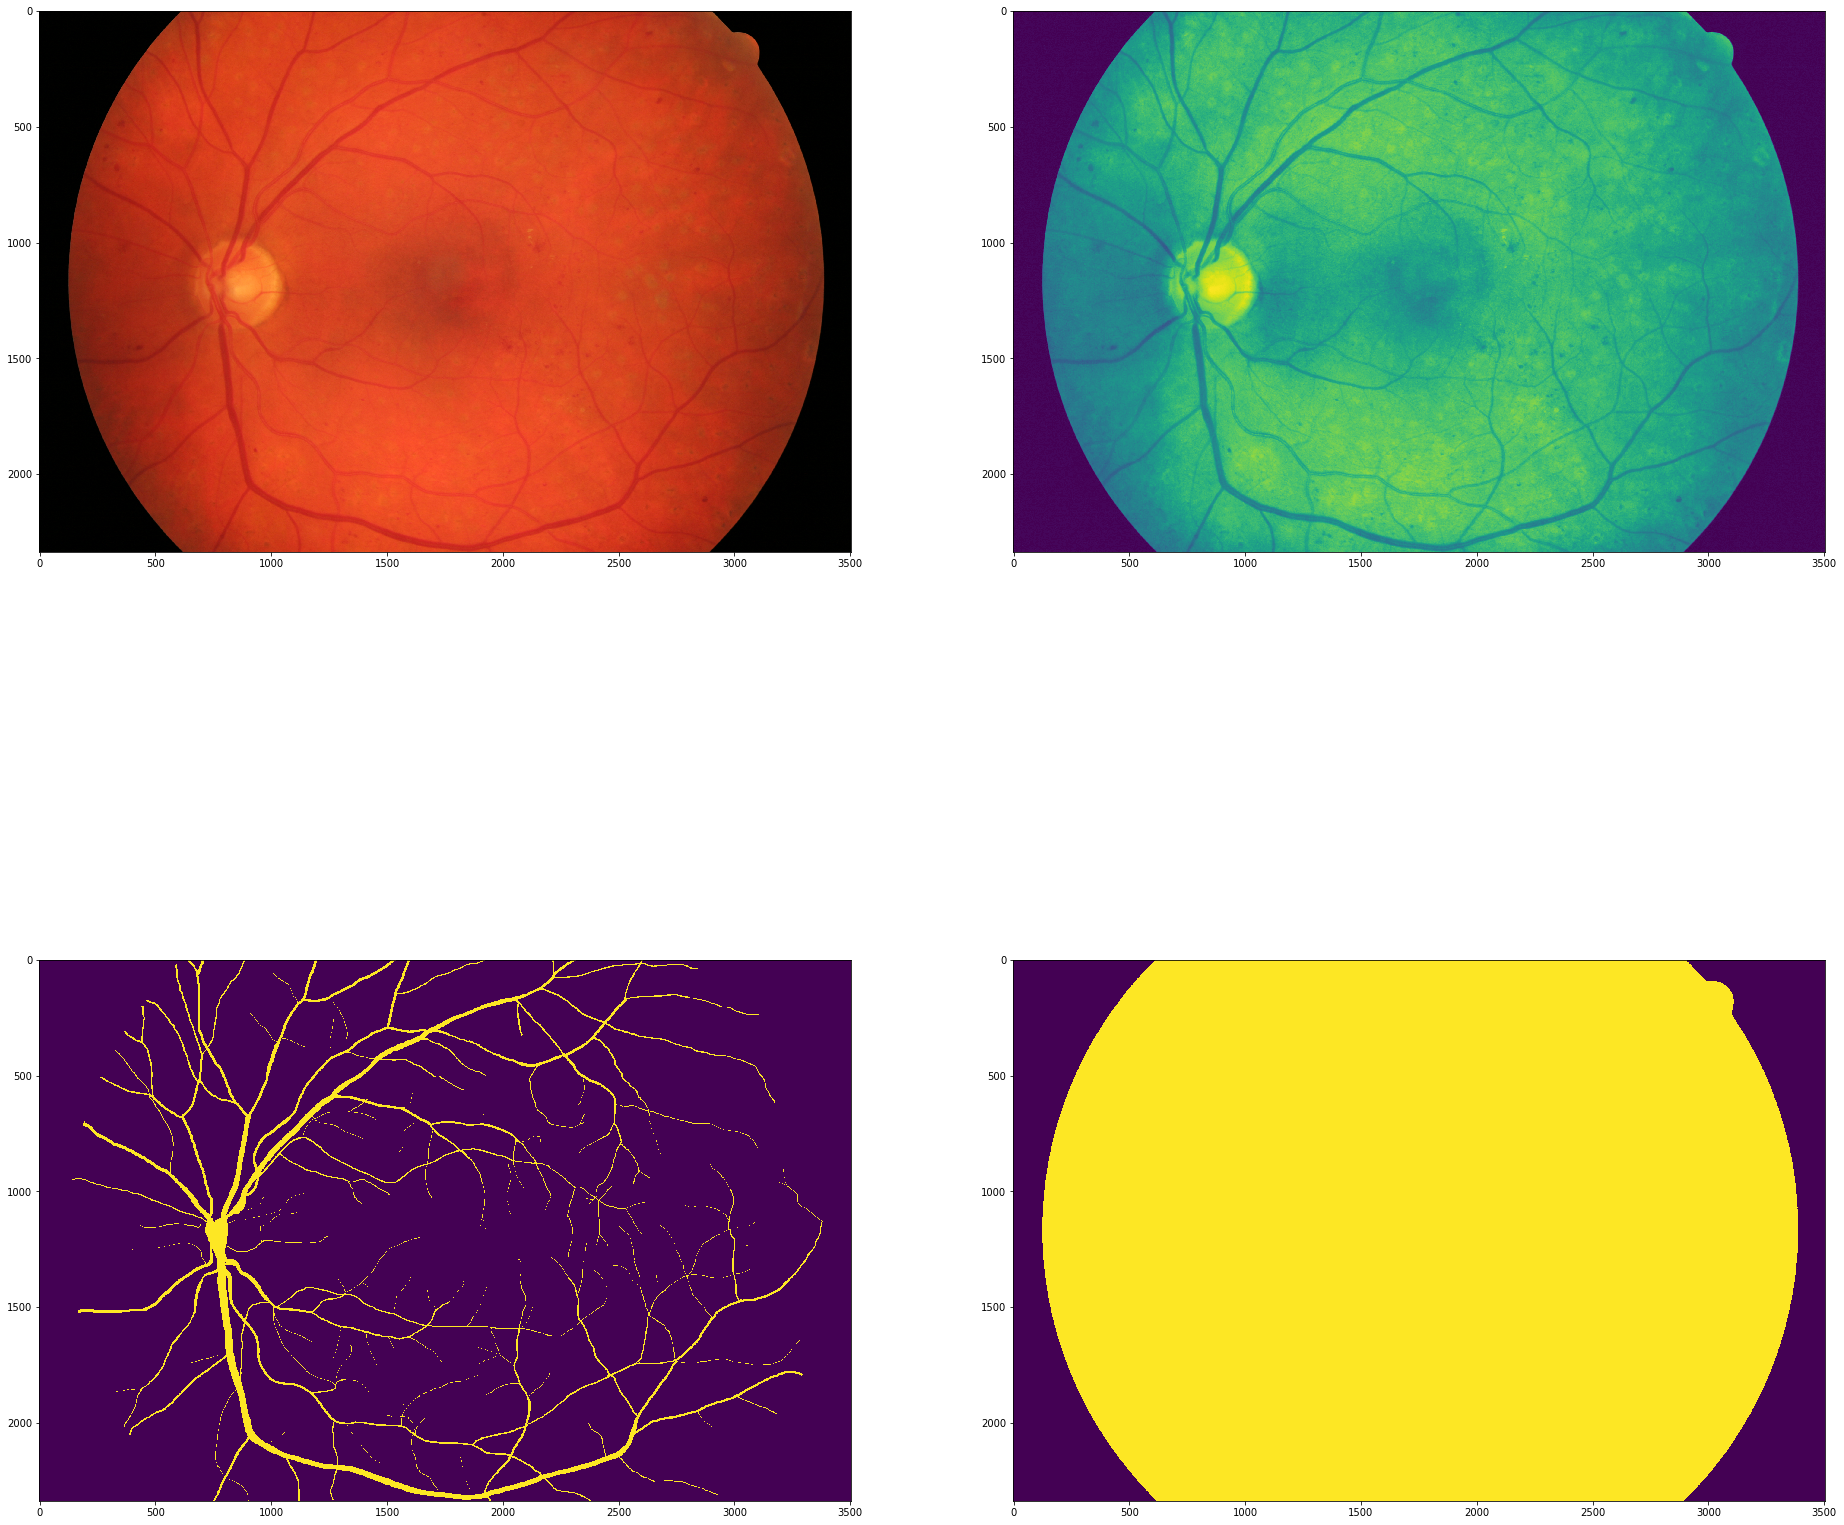

In [ ]:
complete_X, complete_y = None, None
for tensor in create_tensor_from_file():
    tensor.draw_tensor()
    X, y = create_samples_from_tensor(tensor)

    logging.info('Patches were created')
    logging.info('Original dataset shape {}'.format(Counter(y)))
    X, y = random_undersampling(X, y)

    logging.debug('Resampled dataset shape {}'.format(Counter(y)))

    start_index = 0
    end_index = min(start_index + SPLIT_PATCHES_SIZE, len(X))  # tricky way to avoid OutOfIndexError
    logging.info('Splitting set. Range: {}:{} Progress of this tensor: {}% Time: {}'.format(
        start_index, end_index, round(start_index / len(X) * 100), strftime("%Y-%m-%d %H:%M:%S", gmtime())))
    X_subset, y_subset = X[start_index:end_index], y[start_index:end_index]
    logging.info('Cut dataset result countered shape {}'.format(Counter(y_subset)))

    X_subset = np.array(X_subset).reshape(len(X_subset), PATCH_SIZE, PATCH_SIZE, 1)
    y_subset = to_categorical(y_subset)
    logging.debug('Shape X: {}, y: {}'.format(X_subset.shape, y_subset.shape))
    
    
    if complete_X is None:
        complete_X = deepcopy(X_subset)
        complete_y = deepcopy(y_subset)
    else:
        complete_X = np.vstack((complete_X, deepcopy(X_subset)))
        complete_y = np.vstack((complete_y, deepcopy(y_subset)))


print(complete_X.shape)
print(complete_y.shape)
logging.info('Complete dataset result countered shape {}'.format(Counter(complete_y)))


In [11]:
tb_call_back = keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True,
                                                write_images=True)
checkpoint = ModelCheckpoint(FILE_PATH, save_weights_only=False, monitor='val_acc', verbose=0,
                                          save_best_only=True, mode='max')
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(PATCH_SIZE, PATCH_SIZE, 1)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

logging.info('Created keras model')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:root:Created keras model


In [7]:
def predict(model, X):
    input = X
    if len(input.shape) == 2:
        input = input.reshape(1, PATCH_SIZE, PATCH_SIZE, 1)
        logging.debug('Reshaped before prediction')
    result = model.predict(input)
    logging.debug('Predicted: {}, return {}'.format(result, np.argmax(result)))
    logging.debug('For: {}'.format(input))
    return result

In [ ]:
model.fit(X, y, validation_split=0.1, epochs=150, batch_size=32, callbacks=[tb_call_back, checkpoint], verbose=1)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.load_weights(FILE_PATH)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
!rm -rf tb_logs* Graph